IMPORT PACKAGES

In [ ]:
import datetime as dt
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
import requests
from sklearn.linear_model import LinearRegression as linreg
import warnings
warnings.filterwarnings("ignore")

GATHERING SPY ETF UNDERLYING ASSET DATA

In [ ]:
ssga = "https://www.ssga.com/us/en/individual/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx"
spy_listings = list(pd.read_excel(ssga, header=4).Ticker.dropna())
data = yf.download(spy_listings, period="10y")
data = data.dropna(how="all", axis=1)
tickers = list(data['Close'])

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  505 of 505 completed
ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['BRK.B', '-']: YFPricesMissingError('possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")')
ERROR:yfinance:['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (period=10y)')


PRICE MOMENTUM FACTORS & IDENTIFYING LONG AND SHORT ASSETS

In [ ]:
class momentum_factors:
    def __init__(self, spy_listings, tickers):
        self.price, self.volume = spy_listings['Close'], spy_listings['Volume']
        self.returns = self.price.pct_change()
        self.tickers = tickers

        self.momentumdf = pd.DataFrame(index=self.tickers)

    def trend(self, input_df):
        self.input_df = input_df
        self.trend_df = pd.DataFrame(index=self.tickers)

        for i in range(1, 21):
            self.trend_df[i] = np.polyfit(
                range(252),
                self.input_df[-i-252: -i],
                1,
            )[0]

        return self.trend_df.mean(axis=1)

    def price_momentumfactors(self):

        # Run 52-Wk Trend Func.
        self.momentumdf["trend"] = self.trend(input_df=self.price)

        # Percent Above
        self.roll_min = self.price.rolling(252).min()
        self.momentumdf["pct_above"] = ((self.price - self.roll_min) / self.roll_min)[-20:].mean()

        # Price Osc.
        self.rolling_260 = self.price.rolling(260)
        self.momentumdf["p_osc"] = (
            (self.price.rolling(20).mean() - self.rolling_260.mean()) /
            self.rolling_260.std()
        )[-20:].mean()

        # 39-Wk Ret.
        self.momentumdf["39_wk_ret"] = self.price.pct_change(189)[-20:].mean()

        # Price Vol. Trend
        self.price_volumedf = self.price * self.volume
        self.momentumdf["price_volume"] = self.trend(input_df=self.price_volumedf)

        return ((self.momentumdf - self.momentumdf.mean()) / self.momentumdf.std()).sum(axis=1)

    def baskets(self):
          self.momentumscore = self.price_momentumfactors()
          self.z_scored = self.momentumscore

          return self.z_scored.nlargest(10).index, self.z_scored.nsmallest(10).index


BACKTESTING

In [ ]:
backtestlngth = 5
end = dt.datetime.today()
start = end - dt.timedelta(365.25 * backtestlngth)
freq = "M"
hist_rets = data['Close'].pct_change().resample('M').sum().shift(-1)
rangendtes = pd.DataFrame(pd.date_range('2018-12-01', dt.datetime.today(), freq ='M'))
rangendtes.rename (columns = {0: 'date'}, inplace = True)
longreturn, shortreturn = pd.DataFrame(), pd.DataFrame()

for date in rangendtes.date:
    try:
        MF = momentum_factors(data[data.index <= date], tickers)
        longbasket, shrtbasket = MF.baskets()
        longreturn = pd.concat([longreturn, hist_rets.loc[[date], longbasket]])
        shortreturn = pd.concat([shortreturn, hist_rets.loc[[date], shrtbasket]])
    except:
        pass

VISUALIZATIONS

[*********************100%***********************]  1 of 1 completed


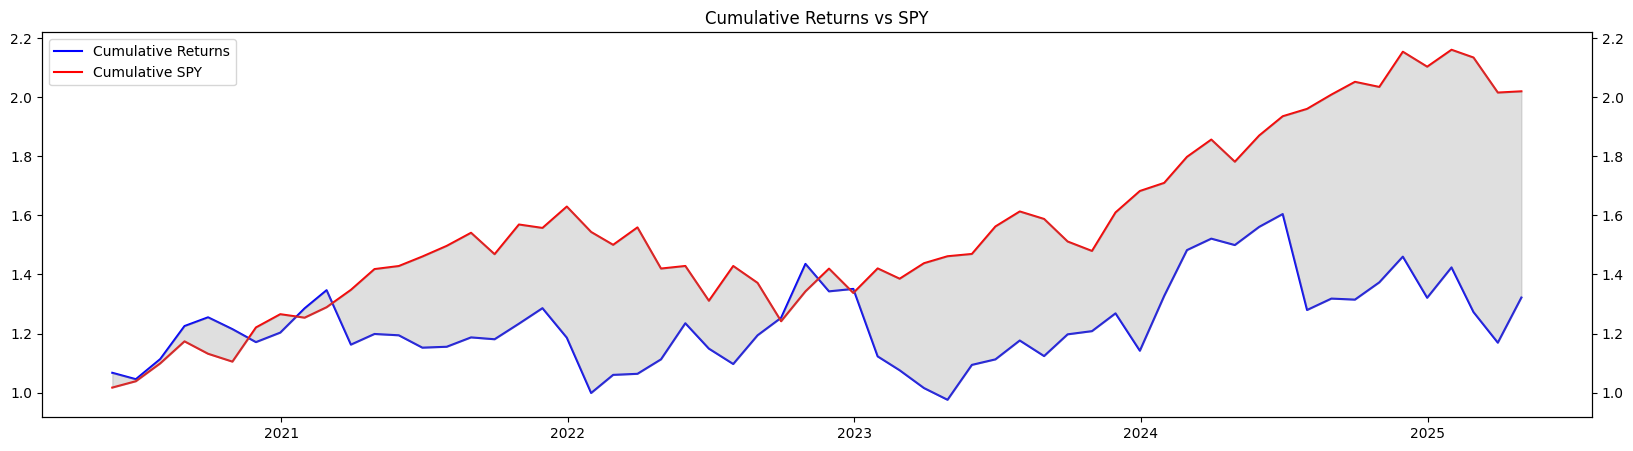

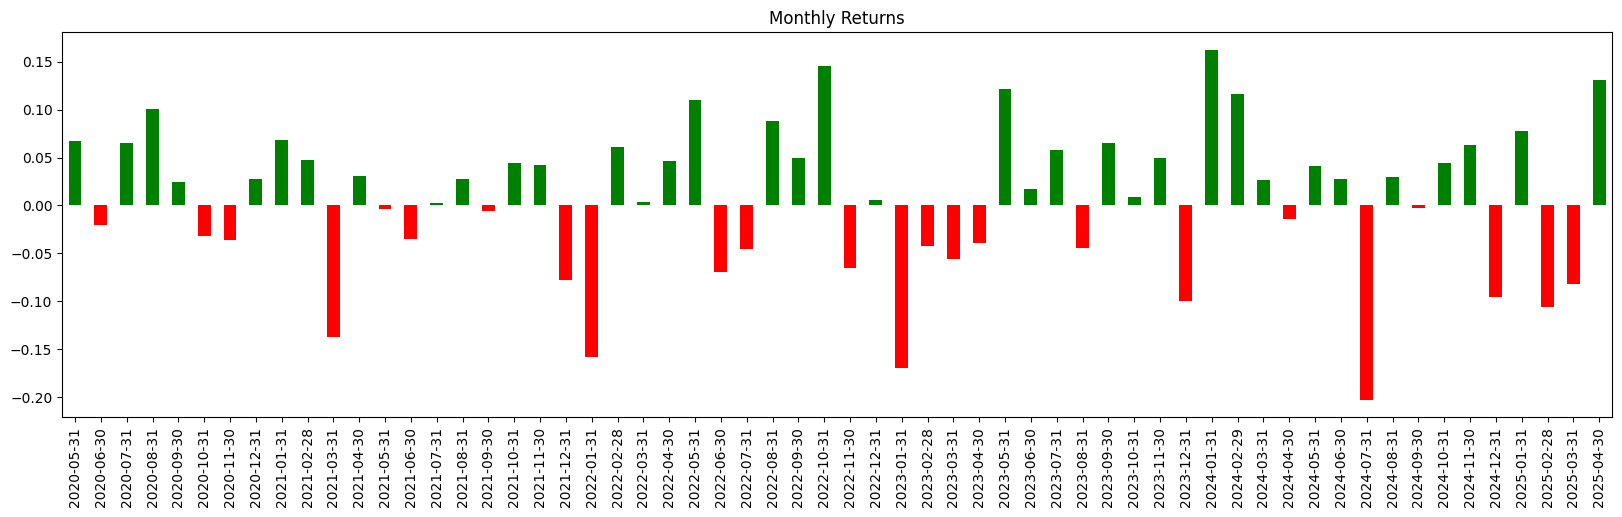

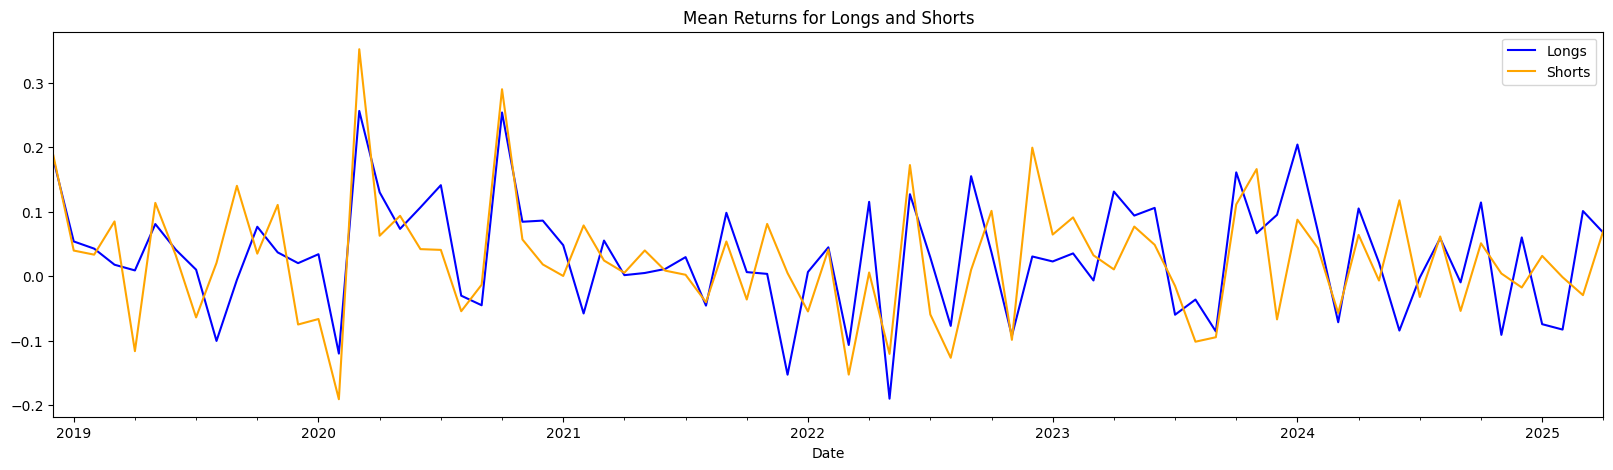

In [ ]:
# Calculate Total Returns
tottsretrns = pd.DataFrame((longreturn.mean(axis=1) - shortreturn.mean(axis=1)).shift(), columns=["tottsretrns"])
tottsretrns = tottsretrns[-60:]

# GRAPH 1: Cumulative Returns and Comparison with SPY
# Calculate cumulative returns
tottsretrns["cum_ret"] = np.exp(np.log1p(tottsretrns["tottsretrns"]).cumsum())

# Fetch and calculate SPY cumulative returns
spy_data = yf.download("SPY", period="5y")
spy_monthly_returns = spy_data["Close"].pct_change().resample("ME").sum()
tottsretrns["spy"] = spy_monthly_returns

tottsretrns["cum_spy"] = np.exp(np.log1p(tottsretrns["spy"].fillna(0)).cumsum())

# Calculate additional metrics
tottsretrns["pos"] = tottsretrns["tottsretrns"] > 0
tottsretrns["cum_vs"] = tottsretrns["cum_ret"] - tottsretrns["cum_spy"]
tottsretrns["cum_pos"] = tottsretrns["cum_vs"] > 0

# Convert index to date
tottsretrns.index = tottsretrns.index.date

# Plot cumulative returns
figure, ax1 = plt.subplots(figsize=(20, 5))
ax2 = ax1.twinx()

x = tottsretrns.index
ax2.fill_between(x, tottsretrns["cum_ret"], tottsretrns["cum_spy"], alpha=0.25, color="gray")
ax1.plot(x, tottsretrns["cum_ret"], label="Cumulative Returns", color="blue")
ax1.plot(x, tottsretrns["cum_spy"], label="Cumulative SPY", color="red")

ax1.legend(loc="upper left")
plt.title("Cumulative Returns vs SPY")
plt.show()

# GRAPH 2: Bar Plot of Total Returns with Positive/Negative Coloring
figure, ax2 = plt.subplots(figsize=(20, 5))
tottsretrns["tottsretrns"].plot(
    kind="bar",
    color=tottsretrns["pos"].map({True: "green", False: "red"}),
    ax=ax2
)

plt.title("Monthly Returns")
plt.show()

# GRAPH 3: Mean Returns for Longs and Shorts
figure, ax = plt.subplots(figsize=(20, 5))
longreturn.mean(axis=1).plot(label="Longs", color="blue", ax=ax)
shortreturn.mean(axis=1).plot(label="Shorts", color="orange", ax=ax)

plt.legend()
plt.title("Mean Returns for Longs and Shorts")
plt.show()


ASSESS WEIGHT OF LONG BASKET

In [ ]:
 stocks = longbasket.tolist()
 end_date = dt.datetime.today()
start_date = end_date - dt.timedelta(2*365)
price = yf.download(stocks, period = '2y')['Close'].pct_change().dropna()
returns = price


[*********************100%***********************]  10 of 10 completed


CLASS FOR EFFICIENT FRONTIER USING MONTE CARLO METHOD

In [ ]:
class EfficientFrontier:
    def __init__(self,returns, assets):
        self.returns = returns
        self.assets = assets

    def Calc(self):
        self.tbl = pd.DataFrame(index = self.assets)
        self.tbl['Mean'] = self.returns.mean()
        self.tbl['Variance'] = self.returns.var()
        return self.tbl.T

   #CORRELATION
    def correlation(self):
        self.tbl = pd.DataFrame(index = self.assets)
        self.corr = self.returns.corr()
        return self.corr

    #PORTFOLIO RETURN
    def PortfolioReturn(self, weight):
        return np.sum(self.returns.mean() * weight) * 252

    #VOLATILITY
    def PortfolioVolatility(self, weight):
        return np.sqrt(np.dot(weight.T, np.dot(self.returns.cov() * 252, weight)))

    #MONTE CARLO
    def MonteCarlo(self, simulations = 100000):
        returnCol = []
        volatilityCol = []
        weightsCol = []
        sharperatioCol = []

        for i in range (simulations):
            weights = np.random.random(len(stocks))
            weights /= np.sum(weights)
            weightsCol.append(weights)
            port_return = self.PortfolioReturn(weights)
            port_volatility = self.PortfolioVolatility(weights)
            returnCol.append(port_return)
            volatilityCol.append(port_volatility)
            sharperatioCol.append((port_return - 0.01) / port_volatility)

        returnCol = np.array(returnCol)
        volatilityCol = np.array(volatilityCol)
        sharperatioCol = np.array(sharperatioCol)

        max_sharpe_idx = sharperatioCol.argmax()
        optimal_weights = weightsCol[max_sharpe_idx]

        return returnCol, volatilityCol, sharperatioCol, optimal_weights

#LINEAR REGRESSION
    def sharpeMinzd(self, weight):
        return -(self.PortfolioReturn(weight)-.02) / self.PortfolioVolatility(weight)

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for x in range(len(stocks)))
eWV = np.array(len(stocks) * [1.0 / len(stocks),])

ef = EfficientFrontier(returns=returns, assets=stocks)

sharpeOptimized = sco.minimize(ef.sharpeMinzd,
                             eWV,
                             method = 'SLSQP',
                             bounds = bounds,
                             constraints = constraints)
volOptimized = sco.minimize(ef.PortfolioVolatility,
                            eWV,
                            method = 'SLSQP',
                            bounds = bounds,
                            constraints = constraints)

# Call MonteCarlo and assign the results to variables
returnCol, volatilityCol, sharpe_ratio, optimal_weights = ef.MonteCarlo()

treturns = np.linspace(min(returnCol), max(returnCol), 50)
tvolatility = []

for treturn in treturns:
    cons = ({'type': 'eq', 'fun': lambda x: ef.PortfolioReturn(x) - treturn},
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    res = sco.minimize(ef.PortfolioVolatility, eWV, method='SLSQP', bounds=bounds, constraints=cons)
    tvolatility.append(res['fun'])

tvolatility = np.array(tvolatility)

AVG AND VARIANCE IN TICKER

In [ ]:
print('Mean and Variance Table: ')
display(ef.Calc().T)

Mean and Variance Table: 


,Mean,Variance
PLTR,0.006814,0.001970
TSLA,0.003322,0.002053
BKNG,0.001597,0.000325
TPL,0.003448,0.001162
GEV,0.004746,0.001276
NFLX,0.002516,0.000435
AXON,0.003484,0.001142
AZO,0.000774,0.000174
FICO,0.001340,0.000549
DASH,0.001607,0.000610


CORRELATION MATRIX

Correlation Matrix: 


Ticker,AXON,AZO,BKNG,DASH,FICO,GEV,NFLX,PLTR,TPL,TSLA
Ticker,,,,,,,,,,
AXON,1.000000,0.013563,0.313503,0.376809,0.453358,0.370522,0.318629,0.483225,0.310832,0.307571
AZO,0.013563,1.000000,0.172851,0.174966,0.170406,0.046908,0.148030,0.099253,0.117349,0.086837
BKNG,0.313503,0.172851,1.000000,0.446882,0.430033,0.512176,0.468821,0.452751,0.351260,0.425002
DASH,0.376809,0.174966,0.446882,1.000000,0.374264,0.451216,0.436312,0.449680,0.364725,0.417400
FICO,0.453358,0.170406,0.430033,0.374264,1.000000,0.367308,0.363487,0.382913,0.328552,0.371090
GEV,0.370522,0.046908,0.512176,0.451216,0.367308,1.000000,0.427578,0.449756,0.438208,0.454199
NFLX,0.318629,0.148030,0.468821,0.436312,0.363487,0.427578,1.000000,0.448445,0.281621,0.379759
PLTR,0.483225,0.099253,0.452751,0.449680,0.382913,0.449756,0.448445,1.000000,0.327128,0.459812
TPL,0.310832,0.117349,0.351260,0.364725,0.328552,0.438208,0.281621,0.327128,1.000000,0.256810


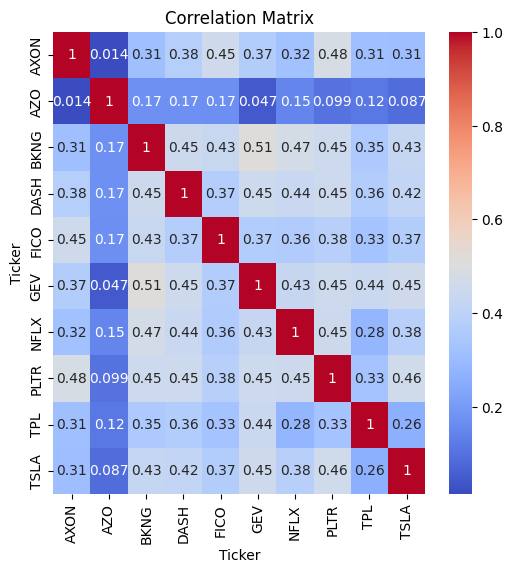

In [ ]:
print('Correlation Matrix: ')
display(ef.correlation())

plt.figure(figsize=(6, 6))
sns.heatmap(returns.corr(), annot=True, cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

EFFICIENT FRONTIER MONTE CARLO PRODUCT

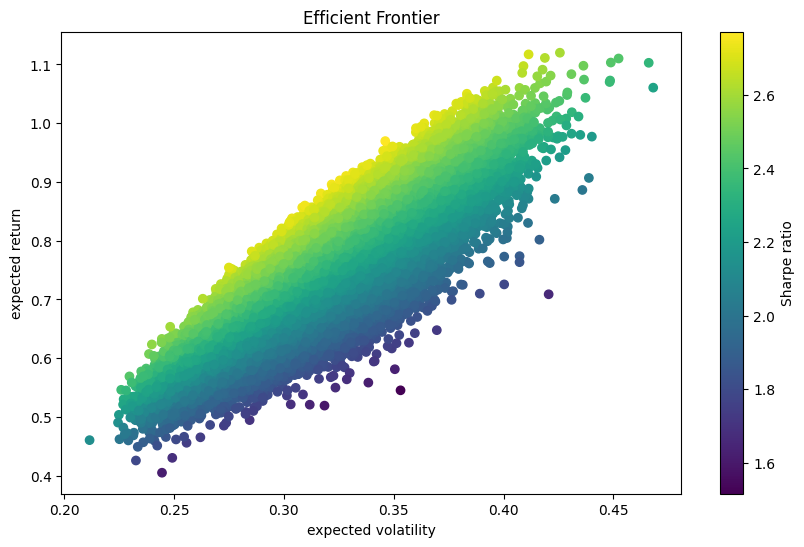

In [ ]:
returnCol, volatilityCol, sharpe_ratio, optimal_weights = ef.MonteCarlo()

plt.figure(figsize = (10, 6))
plt.scatter(volatilityCol, returnCol, c = sharpe_ratio, cmap = 'viridis')
plt.title('Efficient Frontier')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')
plt.show()

POINTS WHICH MAXIMIZED SHARPE RATIO(GOLD)
AND POINT THAT MINIMIZED VOLATILITY(RED)

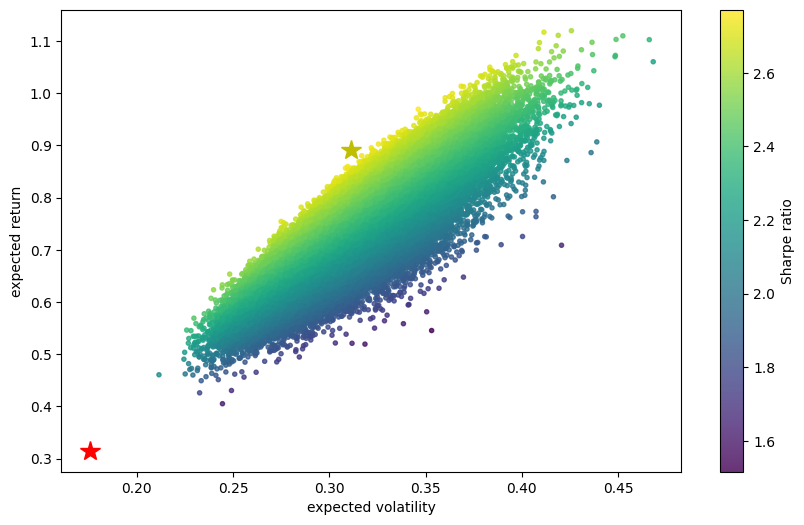

In [ ]:
plt.figure(figsize = (10, 6))
plt.scatter(volatilityCol, returnCol, c = sharpe_ratio,marker='.', alpha=0.8, cmap='viridis')
plt.plot(ef.PortfolioVolatility(sharpeOptimized['x']), ef.PortfolioReturn(sharpeOptimized['x']),
         'y*', markersize = 15.0)
plt.plot(ef.PortfolioVolatility(volOptimized['x']), ef.PortfolioReturn(volOptimized['x']),
         'r*', markersize = 15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')